<a href="https://colab.research.google.com/github/ngcheeyuan/Learner-s-Repo-for-Tensorflow/blob/main/06_scaling_up_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Scaling up to predict all 101 total classes of food

In [1]:
pip install --upgrade matplotlib

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-01-12 11:56:35--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-12 11:56:35 (61.0 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves,unzip_data, compare_historys, walk_through_dir , make_confusion_matrix

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data('101_food_classes_10_percent.zip')

--2022-01-12 11:56:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.128, 173.194.194.128, 173.194.196.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G  38.1MB/s    in 23s     

2022-01-12 11:57:00 (68.9 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [5]:
train_dir = '101_food_classes_10_percent/train'
test_dir = '101_food_classes_10_percent/test'

In [6]:
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spring_rolls'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bruschetta'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/omelette'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/macaroni_and_cheese'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spaghetti_carbonara'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/huevos_rancheros'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/nachos'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/croque_madame'.
There are 0 directories and 250 

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_data = image_dataset_from_directory(directory = train_dir,
                                          label_mode = 'categorical',
                                          image_size = IMG_SIZE,
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)

test_data = image_dataset_from_directory(directory  = test_dir,
                                         label_mode = 'categorical',
                                         image_size = IMG_SIZE,
                                         batch_size = BATCH_SIZE,
                                         shuffle = False) #don't shuffle for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint

check_point_dir = '101_classes_10_percent_data_model_checkpoint'
callback_checkpoint = ModelCheckpoint(check_point_dir,
                                      save_weights_only = True,
                                      monitor = 'val_accuracy',
                                      save_best_only = True)

In [9]:
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.Sequential([preprocessing.RandomHeight(0.2),
                                         preprocessing.RandomWidth(0.2),
                                         preprocessing.RandomRotation(0.2),
                                         #preprocessing.Rescaling(1/255.)  rescale inputs 
                                         preprocessing.RandomFlip('horizontal')
                                         ], name = 'data_augmentation')

In [10]:
from tensorflow.keras import layers
#setup base model
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

#setup input layer
inputs = tf.keras.layers.Input(shape =(224,224,3), name = 'input_layer')

x= data_augmentation(inputs)
x= base_model(x , training = False) # put the model in inference model
x= layers.GlobalAveragePooling2D(name = 'global_avg_pooling_layer')(x)
outputs= layers.Dense(len(train_data.class_names),activation = 'softmax', name = 'output_layer')(x)

model = tf.keras.Model(inputs,outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [12]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

In [13]:
initial_epochs = 5
history = model.fit(train_data,
                    steps_per_epoch = len(train_data),
                    epochs = initial_epochs,
                    validation_data = test_data,
                    validation_steps = int(0.25*len(test_data)),
                    callbacks = [create_tensorboard_callback(dir_name = 'full101_transfer_learning',
                                                             experiment_name = 'baseline_model'),
                                 callback_checkpoint])


Saving TensorBoard log files to: full101_transfer_learning/baseline_model/20220112-115750
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


131/237 [===============>..............] - ETA: 47s - loss: 3.8316 - accuracy: 0.1837

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(test_data)

In [ ]:
plot_loss_curves(history)

In [ ]:
#unfreeze all of the layers in the base model
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
for layer_id,layer in enumerate(base_model.layers):
  print(layer_id,layer.name,layer.trainable)

In [ ]:
model.load_weights(check_point_dir)

In [ ]:
# model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
#               optimizer = tf.keras.optimizers.Adam(),
#               metrics = ['accuracy'])

# history_2 = model.fit(train_data,
#                       steps_per_epoch = len(train_data)
#                       epochs = initial_epochs + 5,
#                       initial_epoch = history.epoch[-1],
#                       validation_data = test_data,
#                       validataion_steps = int(0.25*len(test_data)),
#                       callbacks = [create_tensorboard_callback(dir_name = 'full101_transfer_learning',
#                                                              experiment_name = 'baseline_model'),
#                                  callback_checkpoint]
#                       )

In [ ]:
# compare_historys(history,history_2,initial_epochs = 5)

## Saving our model

In [14]:
model.save('drive/MyDrive')

KeyboardInterrupt: ignored

### Evaluating the performance of the model

In [15]:
import tensorflow as tf
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
unzip_data('06_101_food_class_10_percent_saved_big_dog_model.zip')

--2022-01-12 11:59:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.128, 173.194.194.128, 173.194.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   157MB/s    in 0.3s    

2022-01-12 11:59:22 (157 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [16]:
model = tf.keras.models.load_model('06_101_food_class_10_percent_saved_big_dog_model')

In [17]:
#evaluate loaded model(the one we just downloaded on the test data)
model.evaluate(test_data)

790/790 [==============================] - 105s 130ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

In [18]:
#Make predictions with model
preds_probs = model.predict(test_data,verbose = 1)

790/790 [==============================] - 95s 118ms/step


In [19]:
preds_probs.shape

(25250, 101)

In [20]:
preds_probs[0] , sum(preds_probs[0])

(array([5.9541941e-02, 3.5742332e-06, 4.1376889e-02, 1.0660903e-09,
        8.1613996e-09, 8.6639682e-09, 8.0926134e-07, 8.5652442e-07,
        1.9858850e-05, 8.0977554e-07, 3.1727692e-09, 9.8673388e-07,
        2.8532100e-04, 7.8049661e-10, 7.4230990e-04, 3.8915794e-05,
        6.4740016e-06, 2.4977169e-06, 3.7891397e-05, 2.0678806e-07,
        1.5538471e-05, 8.1506892e-07, 2.6230925e-06, 2.0010653e-07,
        8.3827712e-07, 5.4215743e-06, 3.7391112e-06, 1.3150788e-08,
        2.7761345e-03, 2.8051816e-05, 6.8561651e-10, 2.5574524e-05,
        1.6688934e-04, 7.6409645e-10, 4.0452869e-04, 1.3150487e-08,
        1.7957433e-06, 1.4448400e-06, 2.3062853e-02, 8.2465459e-07,
        8.5366531e-07, 1.7138503e-06, 7.0526130e-06, 1.8402382e-08,
        2.8553984e-07, 7.9482870e-06, 2.0682012e-06, 1.8525193e-07,
        3.3619781e-08, 3.1522335e-04, 1.0410886e-05, 8.5448306e-07,
        8.4741890e-01, 1.0555387e-05, 4.4094719e-07, 3.7404192e-05,
        3.5306137e-05, 3.2489079e-05, 6.7313988e

In [21]:
import numpy as np
predictions = np.argmax(preds_probs,axis=1)
predictions

array([ 52,   0,   0, ..., 100,  94, 100])

## Now to pair predictions to pair with test labels

In [22]:
test_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 101)), types: (tf.float32, tf.float32)>

In [23]:
y_labels = []
for images , labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

In [24]:
from sklearn.metrics import accuracy_score

In [25]:
accuracy_score(y_labels,predictions)

0.6077623762376237

In [26]:
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [27]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.
  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.
  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  plt.xticks(rotation = 70 , fontsize = text_size)
  plt.yticks(fontsize = text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

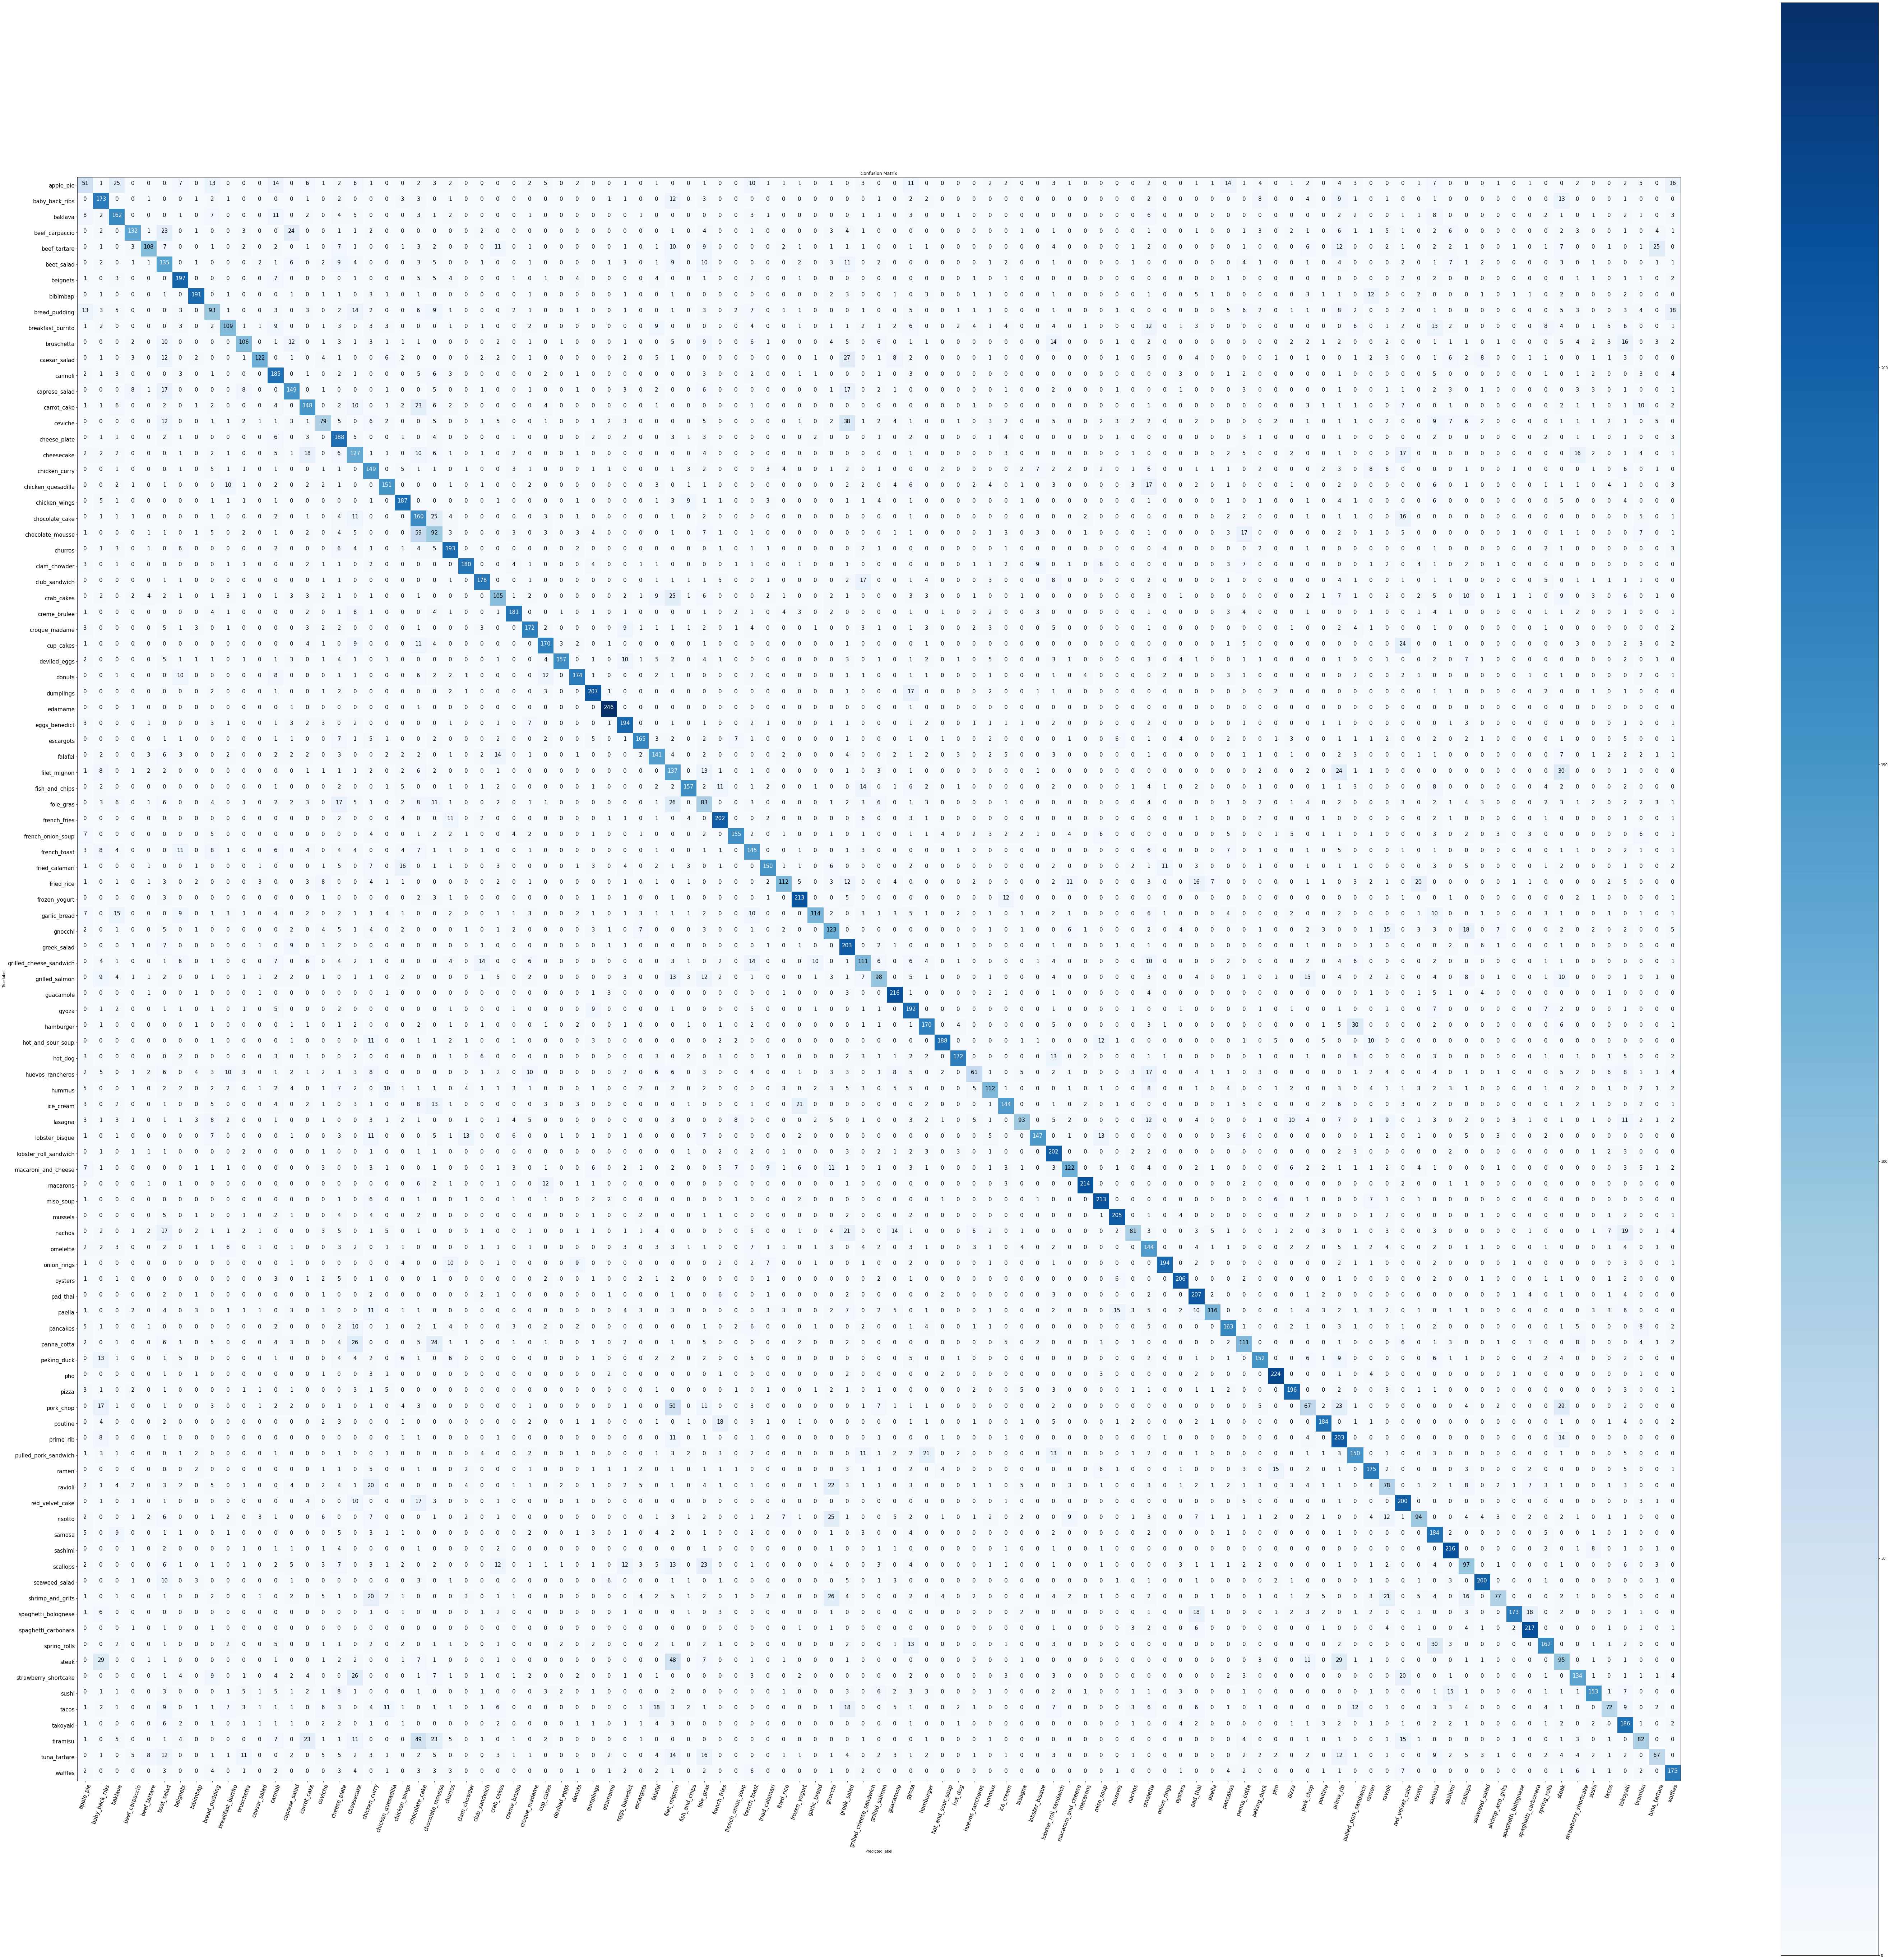

In [28]:
make_confusion_matrix(y_true = y_labels,
                      y_pred = predictions,
                      classes = class_names,
                      figsize = (100,100))

In [29]:
from sklearn.metrics import  classification_report

In [30]:
print(classification_report(y_true = y_labels , y_pred = predictions))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [31]:
# Get a dictionary of the classification report
import pandas as pd
score_df = pd.DataFrame(classification_report(y_true = y_labels , y_pred = predictions,output_dict = True))

In [32]:
column_names = class_names + ['accuracy','macro_avg','weighted_avg']

In [33]:
score_df.columns = column_names
score_df = score_df.T.sort_values(by = 'f1-score', ascending= False)

In [34]:
import seaborn as sns

In [35]:
sns.barplot?

Text(0.5, 1.0, 'f1-scores for 101 different food classes prediction by food vision')

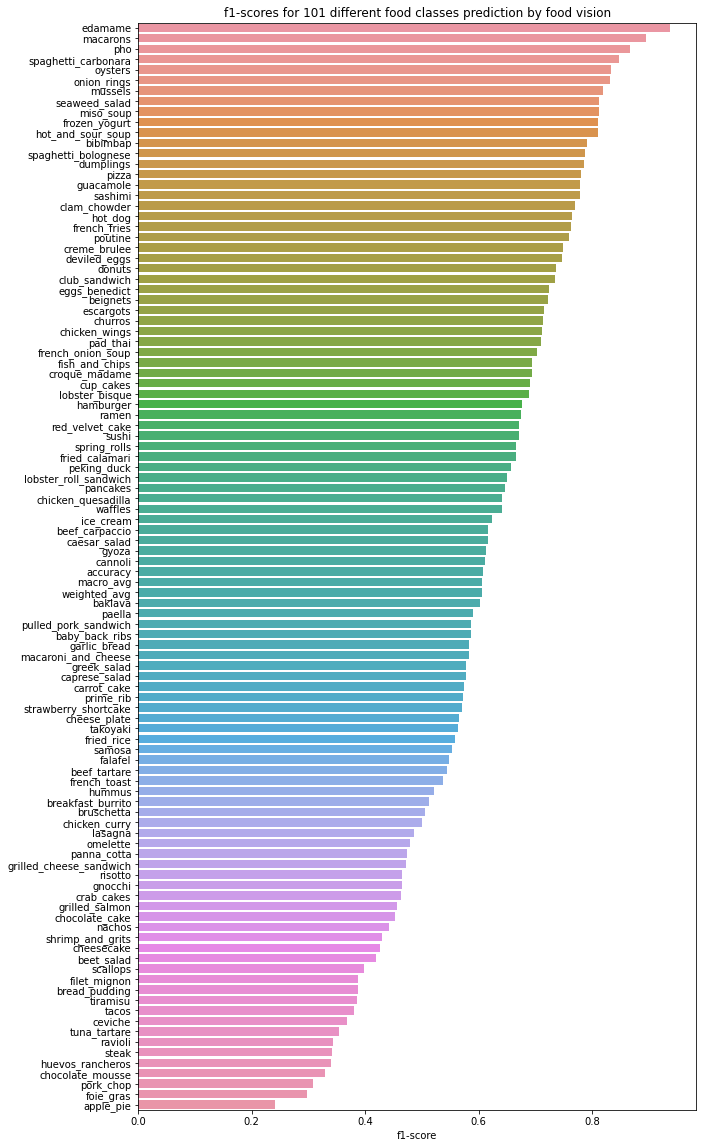

In [36]:
plt.figure(figsize = (10,20))
splot = sns.barplot(data = score_df , y = score_df.index , x = 'f1-score', orient = 'h')
plt.title('f1-scores for 101 different food classes prediction by food vision')
#plt.bar_label(splot.containers[0])

In [37]:
classification_report_dict = classification_report(y_true = y_labels , y_pred = predictions,output_dict = True)

In [38]:
class_f1_scores = {}
for k,v in classification_report_dict.items():
  if k == 'accuracy':
    break
  else:
    class_f1_scores[class_names[int(k)]] = v['f1-score']

In [50]:
# create a function to load and prepare images

def load_and_prep_images(filename, img_shape = 224, scale= True):
  '''
  Reads in an image from filename, turns it into a tensor and reshape into specified shape

  Arg:
  filename (str): path to target image
  image_shape (int): height/width dimension of target image size 
  scale(bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
  Image tensor of shape (image_shape,img_shape,3)
  '''
  # read in the image
  img = tf.io.read_file(filename)
  # Decode image into tensor
  img = tf.io.decode_image(img,channels = 3)
  img = tf.image.resize(img,[img_shape,img_shape])

  #scale? yes/no?

  if scale:
    return img/255.
  else:
    return img

## Lets visualize our predictions

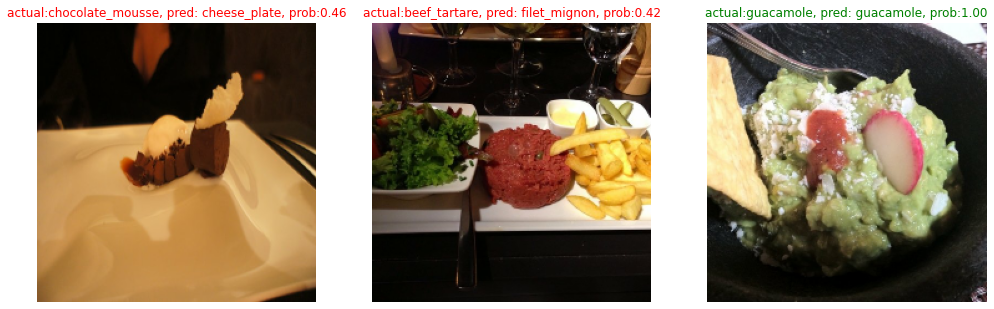

In [104]:
#Make preds on a series of random iamge
import os
import random
plt.figure(figsize = (17,10))

for i in range(3):
  #choose random images from random classes
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir+'/'+class_name))
  filepath = test_dir +  '/' + class_name + '/' + filename
  
  #load the image and make predictions
  img = load_and_prep_images(filepath, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis =0)) # get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()]

  #plot the images
  plt.subplot(1,3,i+1)
  plt.imshow(img/255.)
  if class_name == pred_class:
    title_color = 'g'
  else:
    title_color = 'r'
  plt.title(f'actual:{class_name}, pred: {pred_class}, prob:{pred_prob.max():.2f}', color = title_color)
  plt.axis(False);


## Checking where our model is most wrong
1. Get all of the image file paths in the test dataset using list_files() method
2. create a pd dataframe of the image filepaths , ground truth labels, predicted classes ( from our model), max prediction probabilities
3. Use our dataframe to find all the wrong predictions
4. Sort the dataframe based on wrong predictions
5. visualize the images with the highest prediction

In [41]:
#1. 

filepaths = []
for filepath in test_data.list_files('/content/101_food_classes_10_percent/test/*/*.jpg' , shuffle = False):
  filepaths.append(filepath.numpy())

In [42]:
#2
pred_df = pd.DataFrame({'img_path': filepaths,
                        'y_true': y_labels,
                        'y_pred': predictions,
                        'pred_conf':preds_probs.max(axis=1),
                        'y_true_classname':[class_names[i] for i in y_labels],
                        'y_pred_classname':[class_names[i] for i in predictions]
                        })

In [43]:
pred_df['pred_correct'] = pred_df.y_true == pred_df.y_pred

In [44]:
mask = pred_df['pred_correct'] == False
wrong_predictions = pred_df[mask].copy()

In [58]:
top_100_wrong

img_path  ...  pred_correct
0   b'/content/101_food_classes_10_percent/test/sc...  ...         False
1   b'/content/101_food_classes_10_percent/test/ap...  ...         False
2   b'/content/101_food_classes_10_percent/test/lo...  ...         False
3   b'/content/101_food_classes_10_percent/test/st...  ...         False
4   b'/content/101_food_classes_10_percent/test/sa...  ...         False
..                                                ...  ...           ...
95  b'/content/101_food_classes_10_percent/test/es...  ...         False
96  b'/content/101_food_classes_10_percent/test/br...  ...         False
97  b'/content/101_food_classes_10_percent/test/do...  ...         False
98  b'/content/101_food_classes_10_percent/test/pe...  ...         False
99  b'/content/101_food_classes_10_percent/test/ca...  ...         False

[100 rows x 7 columns]

In [45]:
wrong_predictions.sort_values('pred_conf', ascending = False, inplace = True)

In [46]:
top_100_wrong = wrong_predictions[:100]

In [47]:
top_100_wrong.reset_index(inplace = True, drop = True)

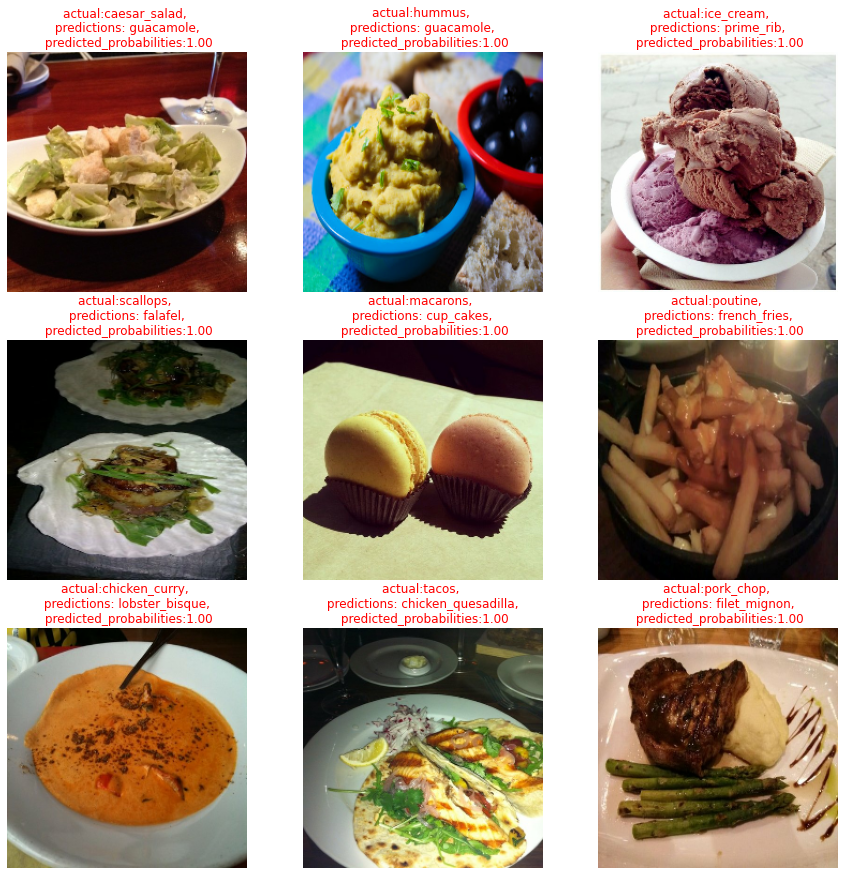

In [81]:
import os
import random
images_to_view = 9
start_index = random.randint(0,91)
plt.figure(figsize = (15,15))

for i,row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3,3,i+1)
  _ , filepath , _, _ ,pred_prob , actual_class , pred_class,_ = row
  img = load_and_prep_images(filepath)
  plt.imshow(img)
  plt.title(f'actual:{actual_class}, \n predictions: {pred_class}, \n predicted_probabilities:{pred_prob:.2f}', color = 'r')
  plt.axis(False);
  # index = random.randint(0,99)
  # filepath = top_100_wrong.iloc[index]['img_path']
  # pred_prob = top_100_wrong.iloc[index]['pred_conf']
  # pred_class = top_100_wrong.iloc[index]['y_pred_classname']
  # actual_class = top_100_wrong.iloc[index]['y_true_classname']
  
  # plt.subplot(1,3,i+1)
  # img = load_and_prep_images(filepath, scale=True)
  # plt.imshow(img)
  # plt.title(f'actual:{actual_class}, pred: {pred_class}, prob:{pred_prob:.2f}', color = 'r')
  # plt.axis(False);

## Test out the model on our own custom images

In [84]:
#get custom images

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data('custom_food_images.zip')

--2022-01-12 12:23:33--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.146.128, 209.85.147.128, 142.250.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.146.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip.1’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.09s   

2022-01-12 12:23:33 (136 MB/s) - ‘custom_food_images.zip.1’ saved [13192985/13192985]



In [86]:
custom_food_images = ['custom_food_images/'+img_path for img_path in os.listdir('custom_food_images')]
custom_food_images

['custom_food_images/ramen.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/sushi.jpeg']

In [103]:
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

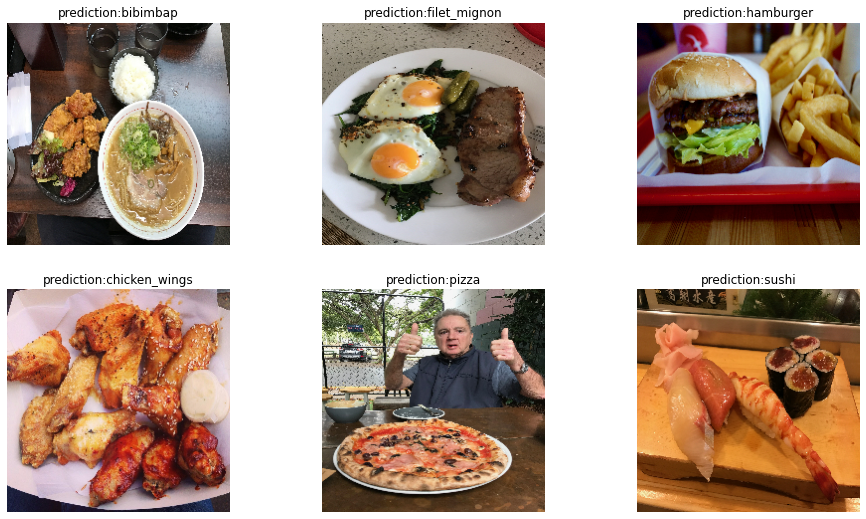

In [107]:
plt.figure(figsize = (16,9))
for i,filepath in enumerate(custom_food_images):
  plt.subplot(2,3,i+1)
  img = load_and_prep_images(filepath,scale = False)
  pred_prob = model.predict(tf.expand_dims(img, axis =0)) # get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()]

  plt.title(f'prediction:{pred_class}')
  plt.imshow(img/255.)
  plt.axis(False)
